<a href="https://colab.research.google.com/github/Mahmoud-Abdellahi/EEG-analyses/blob/main/Task3_topographicalMaps_and_powerAnalyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes



*   The code is running and was tested.
*   The main point to consider is zscoring because in zscoring we center the data by subtracting the mean from data points and then we divide by the standard deviation this is done by using the mean and standard deviation from a baseline duration or another condition that we want to compare our data to.
 So, zscoring will affect the results and it is important to determine the  other condition or what should be used in performing it to get the desired outcome.

*   Please upload data in /content/sample_data/ for example /content/sample_data/EEG Test User 3.edf .. also upload the image that is used for topography which is called BackgroundTopo.png upload it in the same path: /content/sample_data/


*   Figures will be generated in a pdf file called Output figures and can be downloaded after running the file.








# Installs and imports

In [ ]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 53.5 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import mne
import numpy as np
import os
from matplotlib import cm
from scipy import signal, stats
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.backends.backend_pdf import PdfPages

# Functions

In [ ]:
def plot_topographical_power(cfg):
    Bands_freq = cfg['Bands_freq']
    fig, ax = plt.subplots(
        nrows=cfg['rows'], ncols=cfg['cols'], figsize=(15, 10))
    for band_start_idx in range(len(Bands_freq)-1):
        band = [Bands_freq[band_start_idx], Bands_freq[band_start_idx+1]]
        if cfg['individual_freq'] == 0:
            idx = [get_closest(cfg['f'], band[0]),
                   get_closest(cfg['f'], band[1])]
        else:
            idx = [get_closest(cfg['f'], band[0]),
                   get_closest(cfg['f'], band[0])]

        if cfg['pw_choice'] == 'absolute':
            power_band_topo = np.sum(cfg['psd'][:, idx[0]:idx[1]+1], axis=1)
            power_band_topo = stats.zscore(power_band_topo, axis=0)
            fig.suptitle("absolute power")

        elif cfg['pw_choice'] == 'relative':
            power_band_topo = np.sum(
                cfg['psd'][:, idx[0]:idx[1]+1], axis=1) / np.sum(cfg['psd'], axis=1)
            fig.suptitle("relative power")
            power_band_topo = stats.zscore(power_band_topo, axis=0)

        # considers zero index, 1d to 2d index
        row_index, col_index = divmod(band_start_idx, cfg['cols'])

        if band_start_idx == len(Bands_freq)-2:
            # adding the info of the colorbar
            cbar_ax = fig.add_axes([0.92, 0.1, 0.05, 0.7])
            norm = plt.Normalize(vmin=-2.6,
                                 vmax=2.6)  # np.min(power_band_topo)
            sm = cm.ScalarMappable(cmap='jet', norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, cax=cbar_ax)
            cbar.ax.set_title('z-score')

        evoked = mne.EvokedArray(data_refer.get_data(), data_refer.info)
        evoked.set_eeg_reference('average', projection=True)
        power_band_topo = np.interp(power_band_topo, (np.min(
            power_band_topo), np.max(power_band_topo)), (-2.6, 2.6))  # rescaling the values .. zscoring will be done before that this is for plotting within range ..
        evoked = mne.EvokedArray(power_band_topo[:, np.newaxis], evoked.info)
        evoked.plot_topomap(0, ch_type="eeg",
                            show_names=True, contours=0, cmap='jet', size=5,  colorbar=False, axes=ax[row_index][col_index])
        ax[row_index][col_index].set_title(cfg['Bands'][band_start_idx])
    pdf.savefig(fig)

# manual power using the Fourier transform
# def FT(signal, fs, freqs_to_estimate):
#     # Fourier transformation will get the power spectral density (PSD).. power (uV^2 / Hz)
#     # test with a cosine wave
#     fs = 100
#     t = np.arange(0, 4, 1/fs)
#     signal = 4 * np.cos(2*np.pi*2*t)
#     # plt.plot(t, signal)
#     N = len(signal)
#     complex_t = (np.array(range(0, N)) / N)
#     fr = np.array(range(0, N))

#     nyquist = fs/2
#     pts_hz = np.linspace(0, int(nyquist), int((N/2)+1))

#     coeff = np.zeros((N, 1), dtype=np.complex_)
#     for i in range(len(fr)):
#         complex_wave = np.exp(-2*np.pi*1j*fr[i]*complex_t)
#         coeff[i] = np.dot(complex_wave[np.newaxis, :], signal[:, np.newaxis])
#     coeff = coeff/N
#     m = abs(coeff)
#     p = pow(m*2, 2)
#     p[1:-1] *= 2
#     plt.plot(pts_hz, (p[0:len(pts_hz)]))  # plot of the specturm
#     return 1

In [ ]:
def bands_to_ratio(Bands_freq1, Bands_freq2, f, psd):
    band = [Bands_freq1[0], Bands_freq1[1]]
    idx1 = [get_closest(f, band[0]), get_closest(f, band[1])]
    band = [Bands_freq2[0], Bands_freq2[1]]
    idx2 = [get_closest(f, band[0]), get_closest(f, band[1])]
    power_band_topo1 = np.sum(psd[:, idx1[0]:idx1[1]+1], axis=1)
    power_band_topo1 = stats.zscore(power_band_topo1, axis=0)
    power_band_topo2 = np.sum(psd[:, idx2[0]:idx2[1]+1], axis=1)
    power_band_topo2 = stats.zscore(power_band_topo2, axis=0)
    power_band_topo_ratio = power_band_topo1 / power_band_topo2
    return power_band_topo_ratio

In [ ]:
def get_closest(f, num):
    # closest to the frequency value in the estimated frequencies say we want 1 but the closest is 0.999
    return np.where(f == min(f, key=lambda x: abs(x-num)))[0][0]

# Different code blocks

Extracting EDF parameters from /content/sample_data/EEG Test User 3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 120249  =      0.000 ...   480.996 secs...
dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])
250.0
dict_items([('acq_pars', None), ('acq_stim', None), ('ctf_head_t', None), ('description', None), ('dev_ctf_t', None), ('dig', None), ('experimenter', None), ('utc_offset', None), ('device_info', None), ('file_id', None), ('highpass', 0.0), ('hpi_subsystem', None), ('kit_system_id', None), ('helium_inf

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished


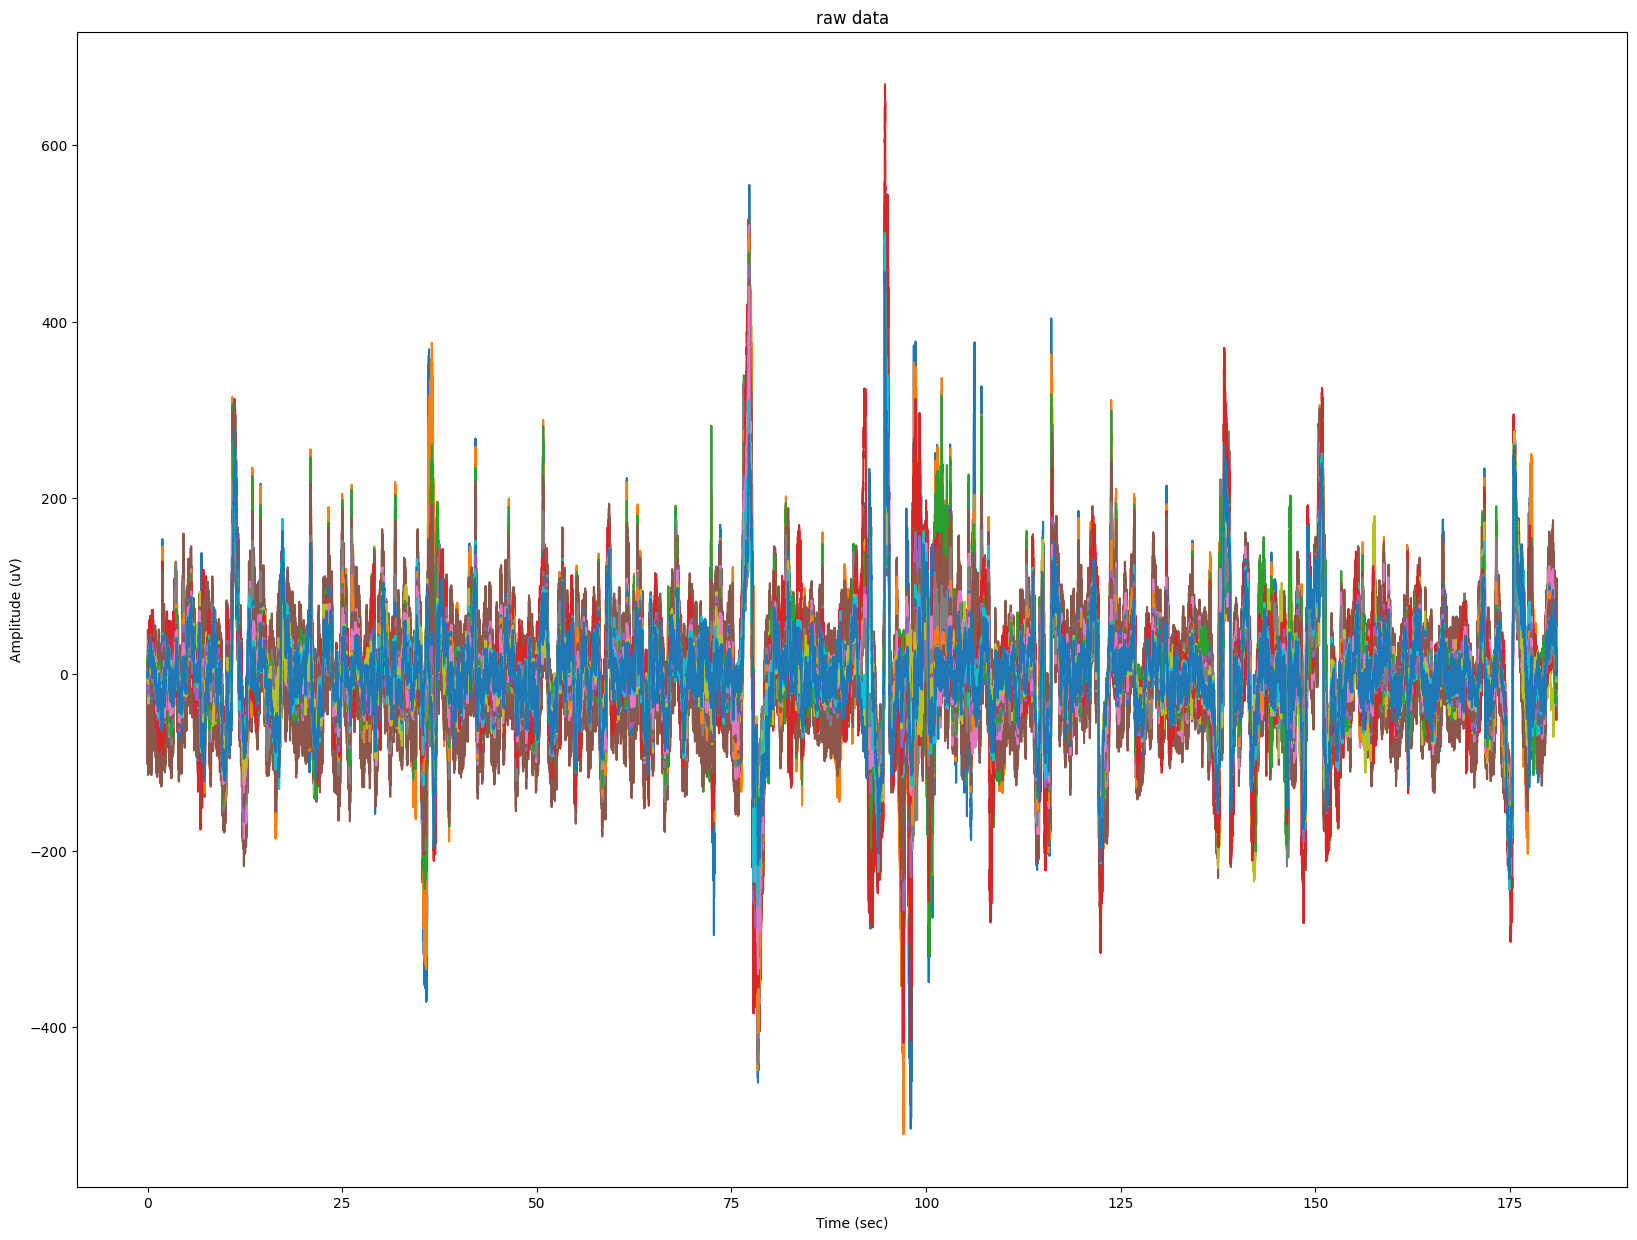

Creating RawArray with float64 data, n_channels=21, n_times=45250
    Range : 0 ... 45249 =      0.000 ...   180.996 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [ ]:
path = '/content/sample_data/'
fName = 'EEG Test User 3'
raw = mne.io.read_raw_edf(path + fName + '.edf', preload=True)
pdf = PdfPages('Output figures.pdf')
# taking the parts after 300seconds because there was noise
raw = raw.crop(tmin=300, tmax=raw.times[-1])


print(raw.info.keys())
print(raw.info['sfreq'])
print(raw.info.items())
raw.ch_names[0:21]  # so EEG from 0 to 21

# choosing the first 21 channels as discussed so the data must include this number of channels at least and have them as EEG channels
raw = raw.pick_channels(raw.info.ch_names[0:21])
raw.info.ch_names


raw = raw.copy().filter(l_freq=0.5, h_freq=70)

# because mne reads it as Volts and we want microVolts to have a normal EEG amplitude
hold_data = (raw.get_data())*1e6


# common average reference
# get the mean across channels and then we repeat this to match the data and then subtract it from the data
data_refer = hold_data - \
    np.repeat(np.mean(hold_data, axis=0)[
              np.newaxis, :], hold_data.shape[0], axis=0)

fig = plt.figure(figsize=(20, 15))
plt.plot(raw.times, hold_data.T)
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude (uV)")
plt.title("raw data")
plt.show()
pdf.savefig(fig)

data_refer = mne.io.RawArray(data_refer, raw.info)
fs = data_refer.info['sfreq']

# renaming channels to match the name in the standard 10 20 montage (remove the EEG prefix)
ch_names_updated = {ch_names: ch_names.replace(
    'EEG ', '') for ch_names in data_refer.ch_names}  # new and old channel names
data_refer.rename_channels(ch_names_updated)
# setting a montage to see topos
montage = mne.channels.make_standard_montage('standard_1020')
data_refer.set_montage(montage)
data_refer.ch_names

channel_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
                 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
data_refer = data_refer.pick_channels(channel_names)

dat = data_refer.get_data()


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


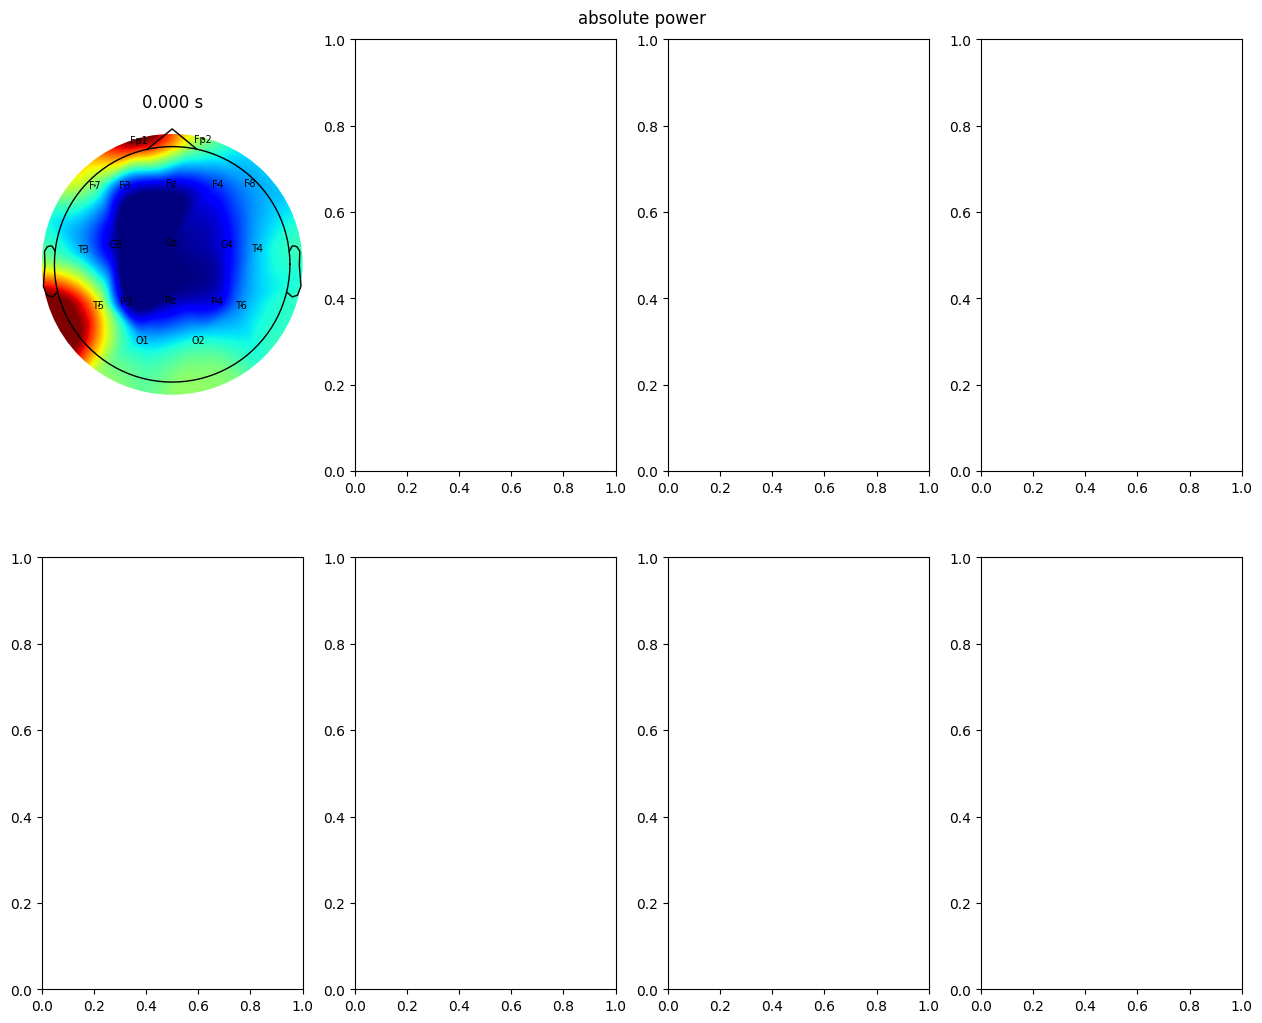

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projecti

In [ ]:
f, psd = signal.periodogram(dat, fs, axis=1, scaling='density')

Bands = ['Delta', 'Theta', 'Alpha1', 'Alpha2',
         'Beta1', 'Beta2', 'Beta3', 'Gamma']
Bands_freq = [1, 4, 8, 10, 12, 15, 20, 30, 45]
rows = 2  # the actual number of rows
cols = 4

# frequency bands
# setting psd, f, Bands, Bands_freq, rows, cols for the function
cfg = dict()
cfg['f'] = f
cfg['psd'] = psd
cfg['Bands'] = Bands
cfg['Bands_freq'] = Bands_freq
cfg['rows'] = rows
cfg['cols'] = cols
cfg['individual_freq'] = 0
cfg['pw_choice'] = 'absolute'
cfg['pdf'] = pdf
plot_topographical_power(cfg)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


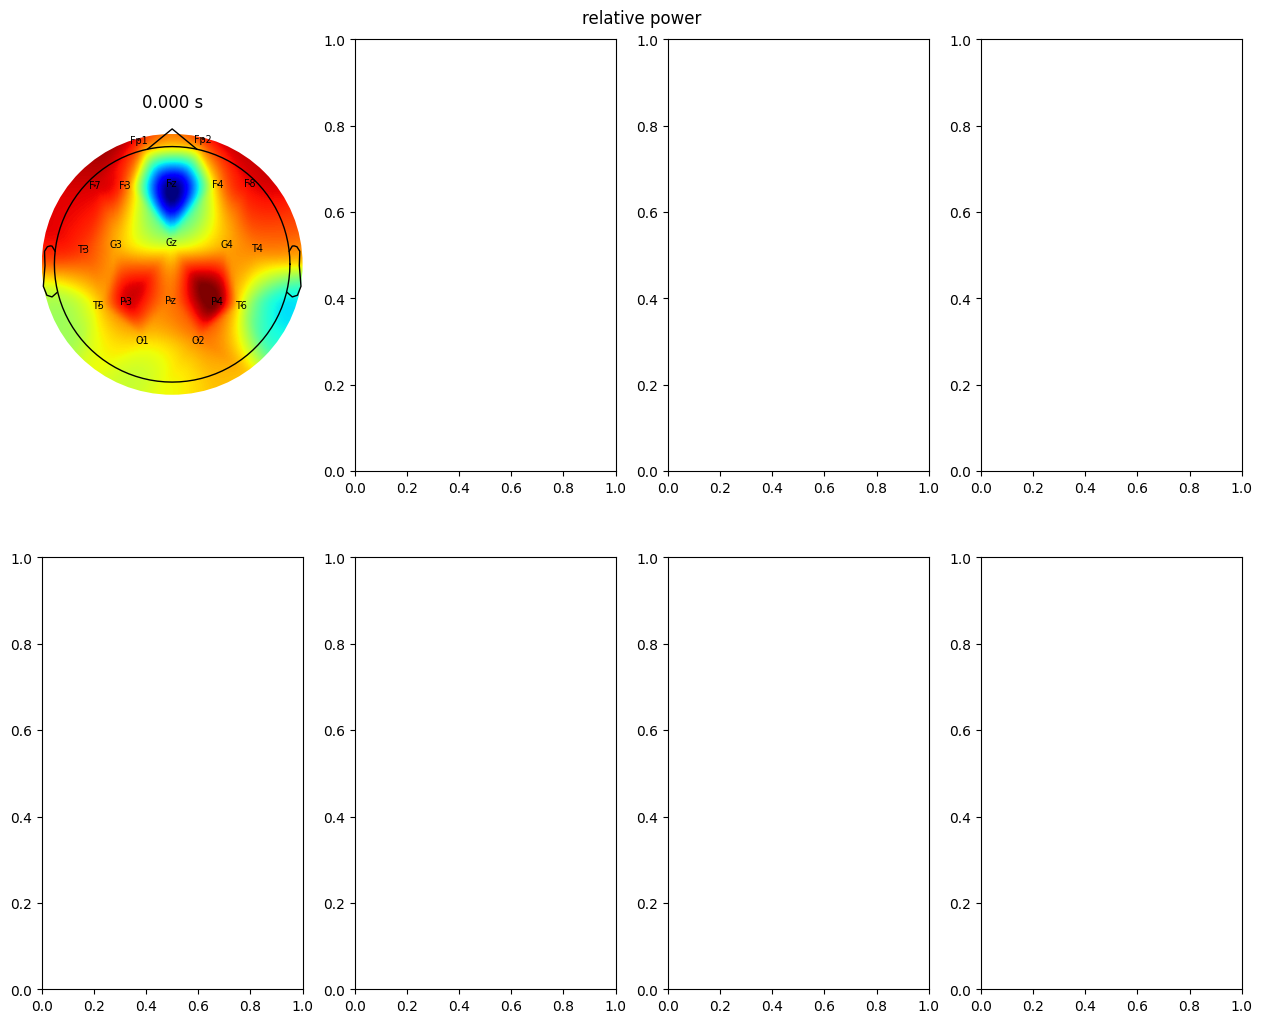

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projecti

In [ ]:
cfg['pw_choice'] = 'relative'
plot_topographical_power(cfg)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


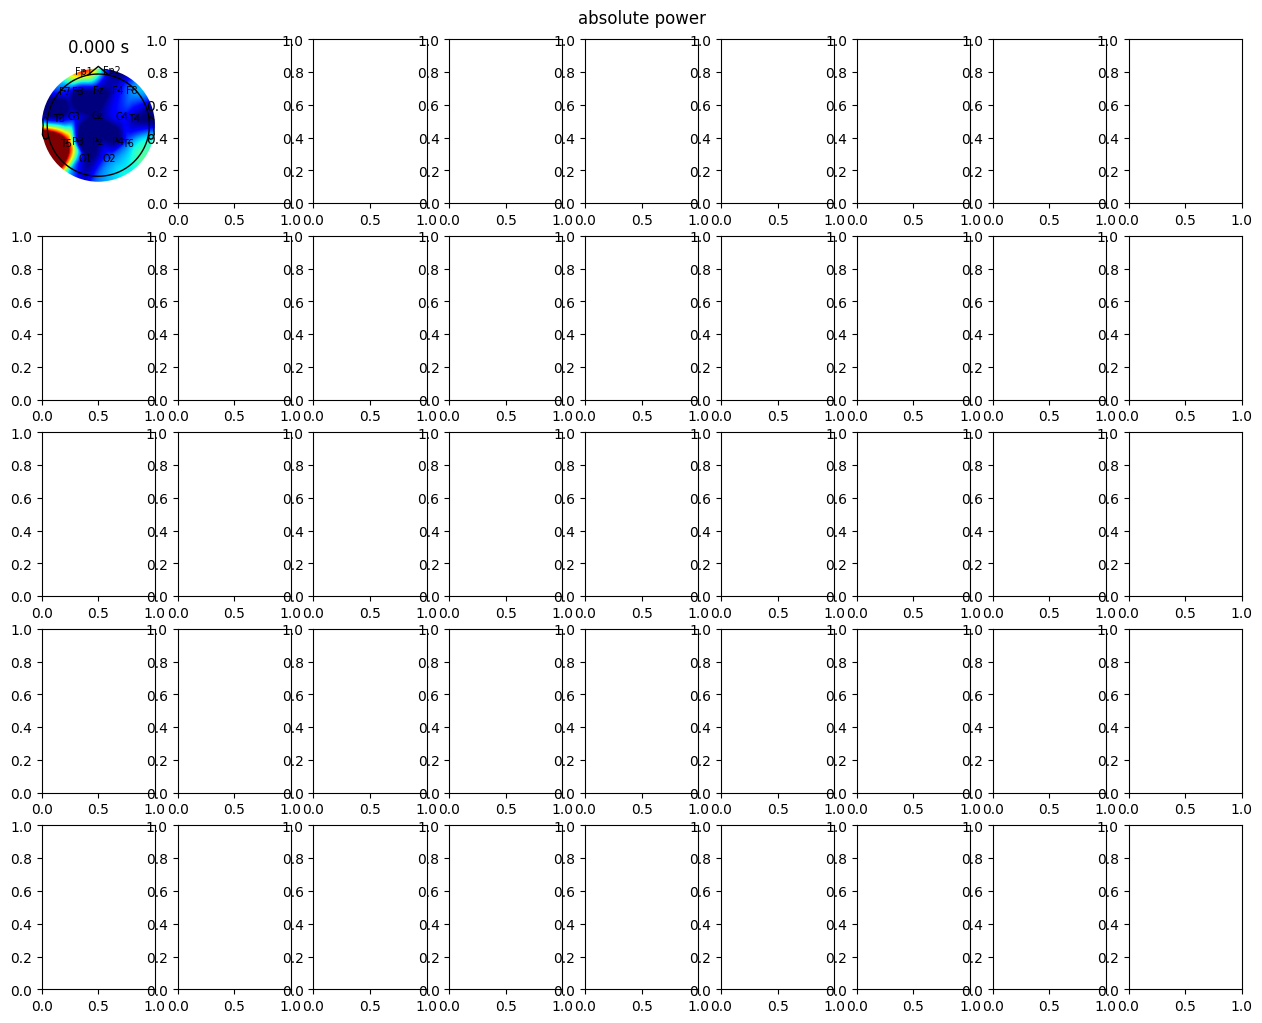

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projecti

In [ ]:
# each frequency
Bands = [str(i) + ' Hz' for i in range(1, 47)]
Bands_freq = [i for i in range(1, 47)]
rows = 5  # the actual number of rows
cols = 9
cfg['Bands'] = Bands
cfg['Bands_freq'] = Bands_freq
cfg['rows'] = rows
cfg['cols'] = cols
cfg['individual_freq'] = 1
cfg['pw_choice'] = 'absolute'
plot_topographical_power(cfg)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


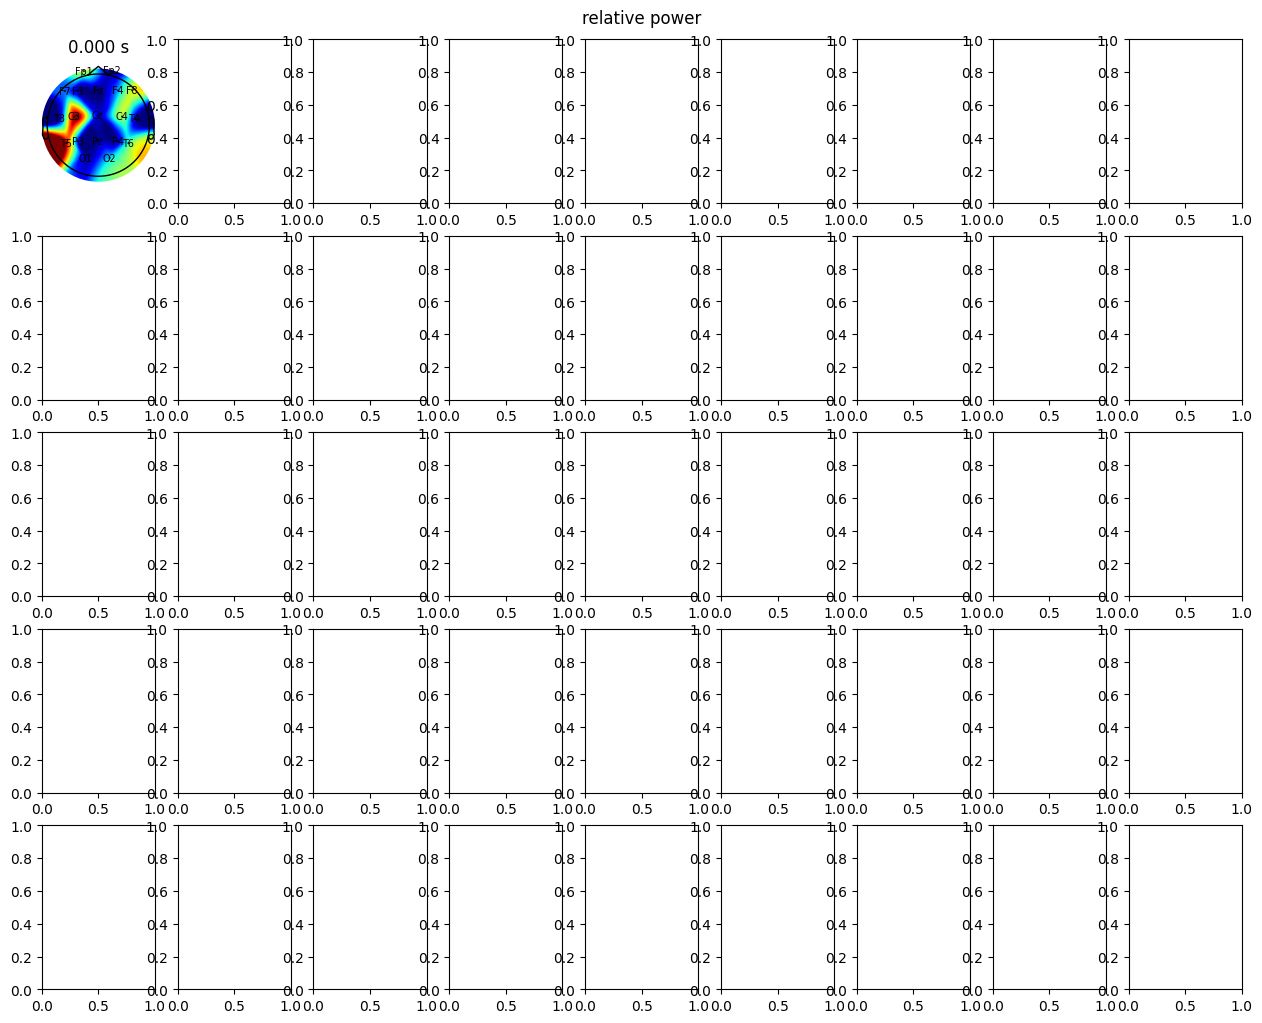

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projecti

In [ ]:
cfg['pw_choice'] = 'relative'
plot_topographical_power(cfg)

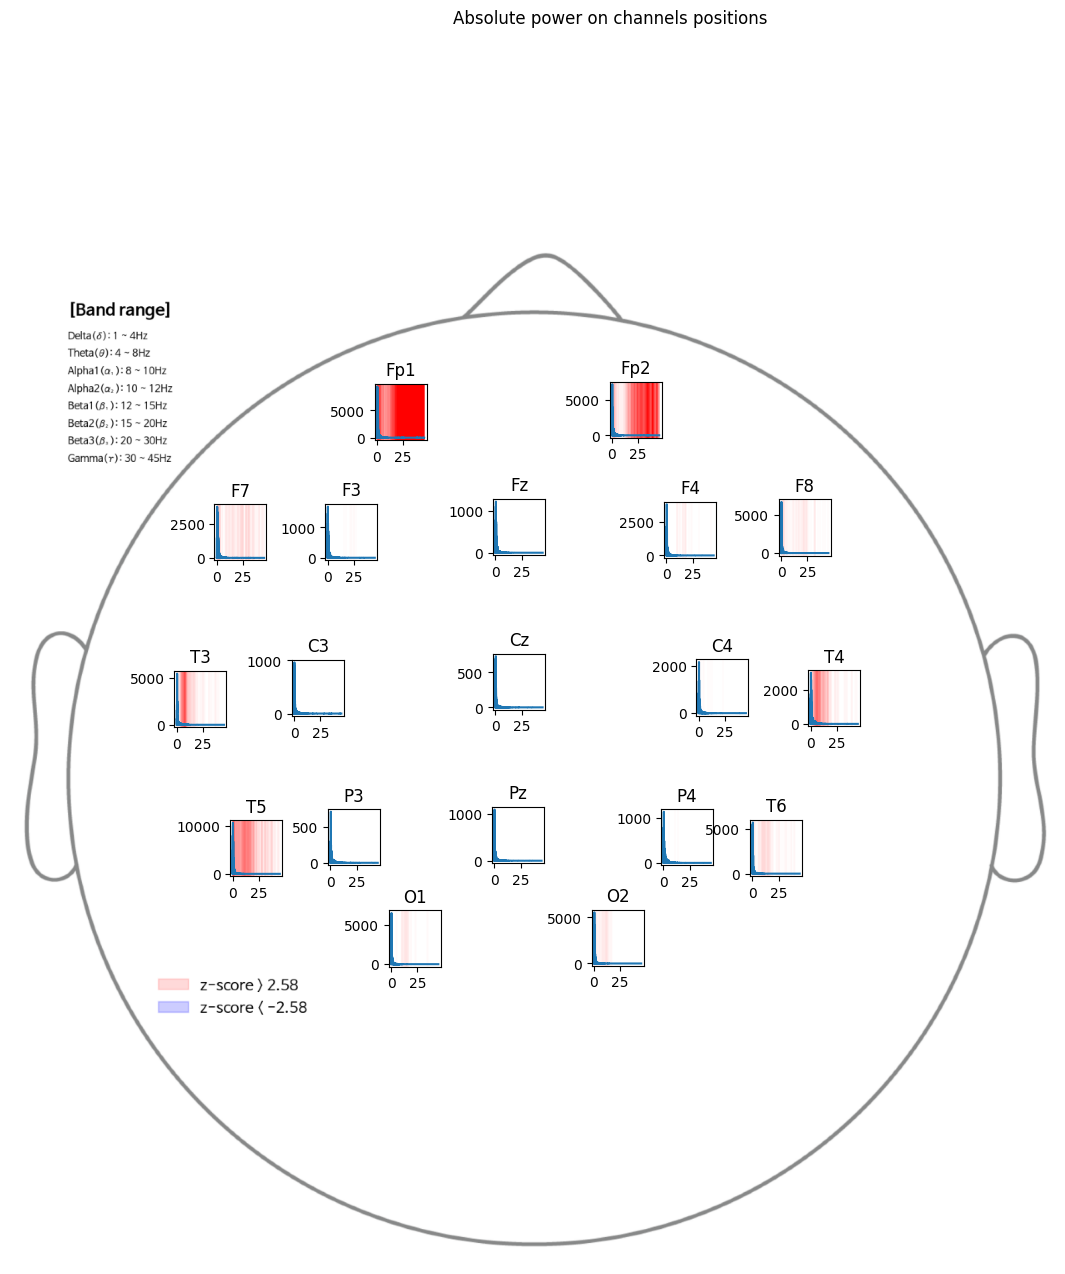

In [ ]:
# %% Absolute power on channels positions
fig, ax = plt.subplots(figsize=(20, 15))
with get_sample_data('/content/sample_data/backgroundTopo.png') as file:
    img = plt.imread(file)
imagebox = OffsetImage(img, zoom=0.6)
ab = AnnotationBbox(imagebox, (0.46, 0.5), xycoords='data', frameon=False)
ax.add_artist(ab)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_visible(False)
# changing the start of plotting the axes and the width and height
ax.set_position([0.2, 0.25, 0.52, 0.5])

layout = mne.channels.make_eeg_layout(data_refer.info)
xy = layout.pos[:, 0:2]
ax.scatter(xy[:, 0], xy[:, 1])

idx = [get_closest(f, 0), get_closest(f, 45)]
psd = psd[:, idx[0]:idx[1]]
psd_z = stats.zscore(psd, axis=0)
f = f[idx[0]:idx[1]]
for i, label in enumerate(layout.names):
    # Add inset subplot at specific location
    inset_ax = inset_axes(ax, width="10%", height="10%", loc=3,
                          bbox_to_anchor=(xy[i, 0], xy[i, 1], 0.5, 0.75), bbox_transform=ax.transAxes)
    inset_ax.set_title(label)
    for j in range(len(f)):
        if psd_z[i, j] > 2.58:
            inset_ax.axvline(x=f[j], color='red', alpha=0.01)
        if psd_z[i, j] < -2.58:
            inset_ax.axvline(x=f[j], color='blue', alpha=0.01)
    inset_ax.plot(f, psd[i, :])

fig.suptitle("Absolute power on channels positions")
pdf.savefig(fig)

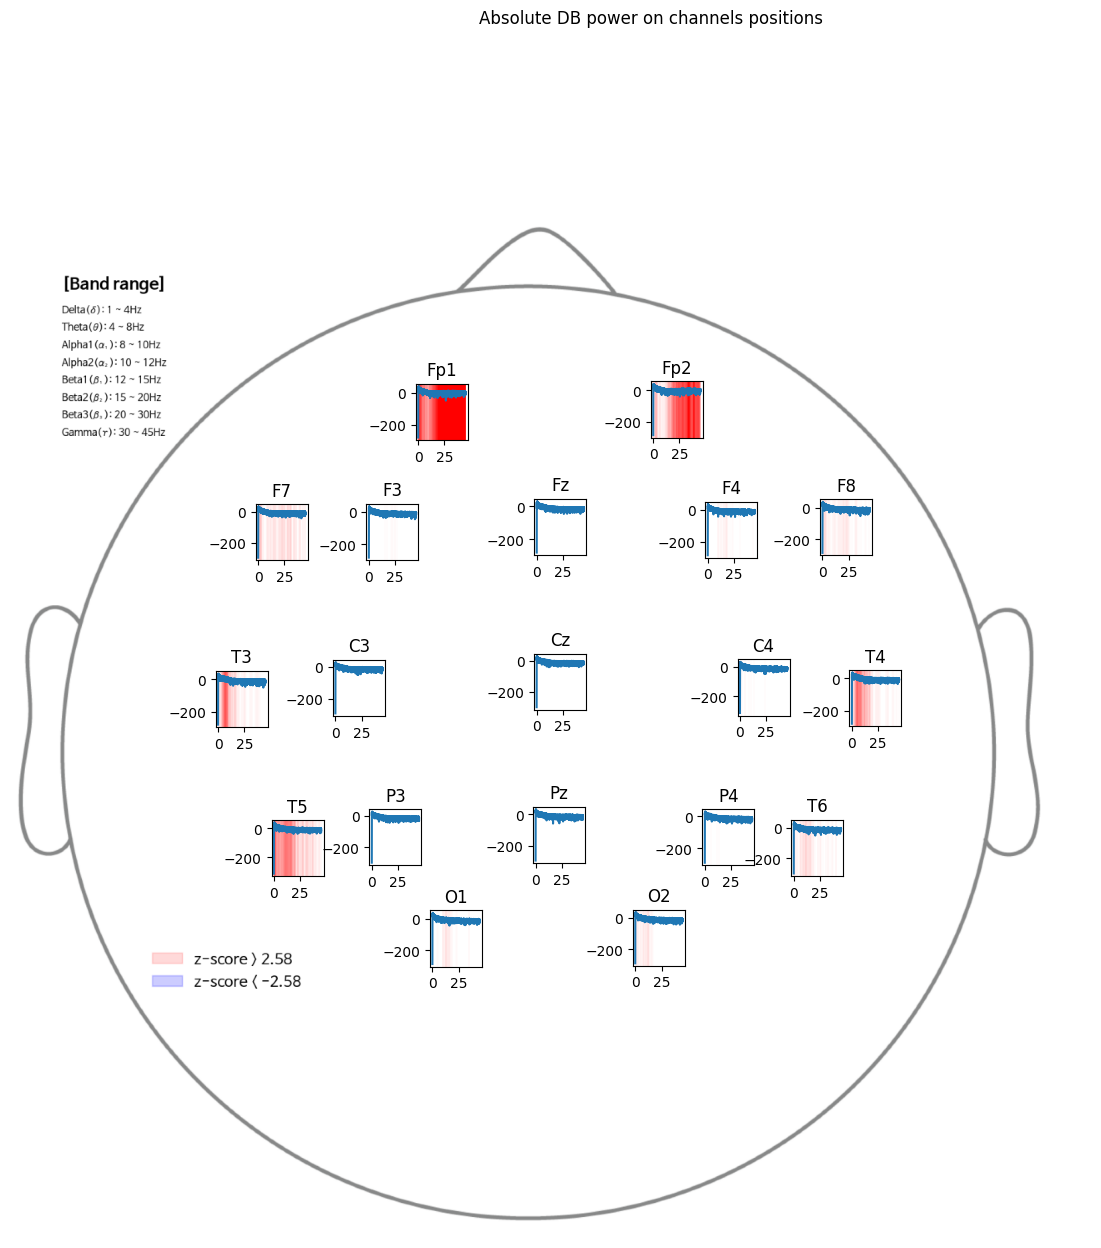

In [ ]:
# %% Absolute DB power on channels positions
fig, ax = plt.subplots(figsize=(20, 15))
with get_sample_data('/content/sample_data/backgroundTopo.png') as file:
    img = plt.imread(file)
imagebox = OffsetImage(img, zoom=0.6)
ab = AnnotationBbox(imagebox, (0.46, 0.5), xycoords='data', frameon=False)
ax.add_artist(ab)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_visible(False)
# changing the start of plotting the axes and the width and height
ax.set_position([0.2, 0.25, 0.52, 0.5])

layout = mne.channels.make_eeg_layout(data_refer.info)
xy = layout.pos[:, 0:2]
# Absolute with DB
for i, label in enumerate(layout.names):
    # Add inset subplot at specific location
    inset_ax = inset_axes(ax, width="10%", height="10%", loc=3,
                          bbox_to_anchor=(xy[i, 0], xy[i, 1], 0.5, 0.75), bbox_transform=ax.transAxes)
    inset_ax.set_title(label)
    for j in range(len(f)):
        if psd_z[i, j] > 2.58:
            inset_ax.axvline(x=f[j], color='red', alpha=0.01)
        if psd_z[i, j] < -2.58:
            inset_ax.axvline(x=f[j], color='blue', alpha=0.01)
    inset_ax.plot(f, 10*np.log10(psd[i, :]))
fig.suptitle("Absolute DB power on channels positions")
pdf.savefig(fig)

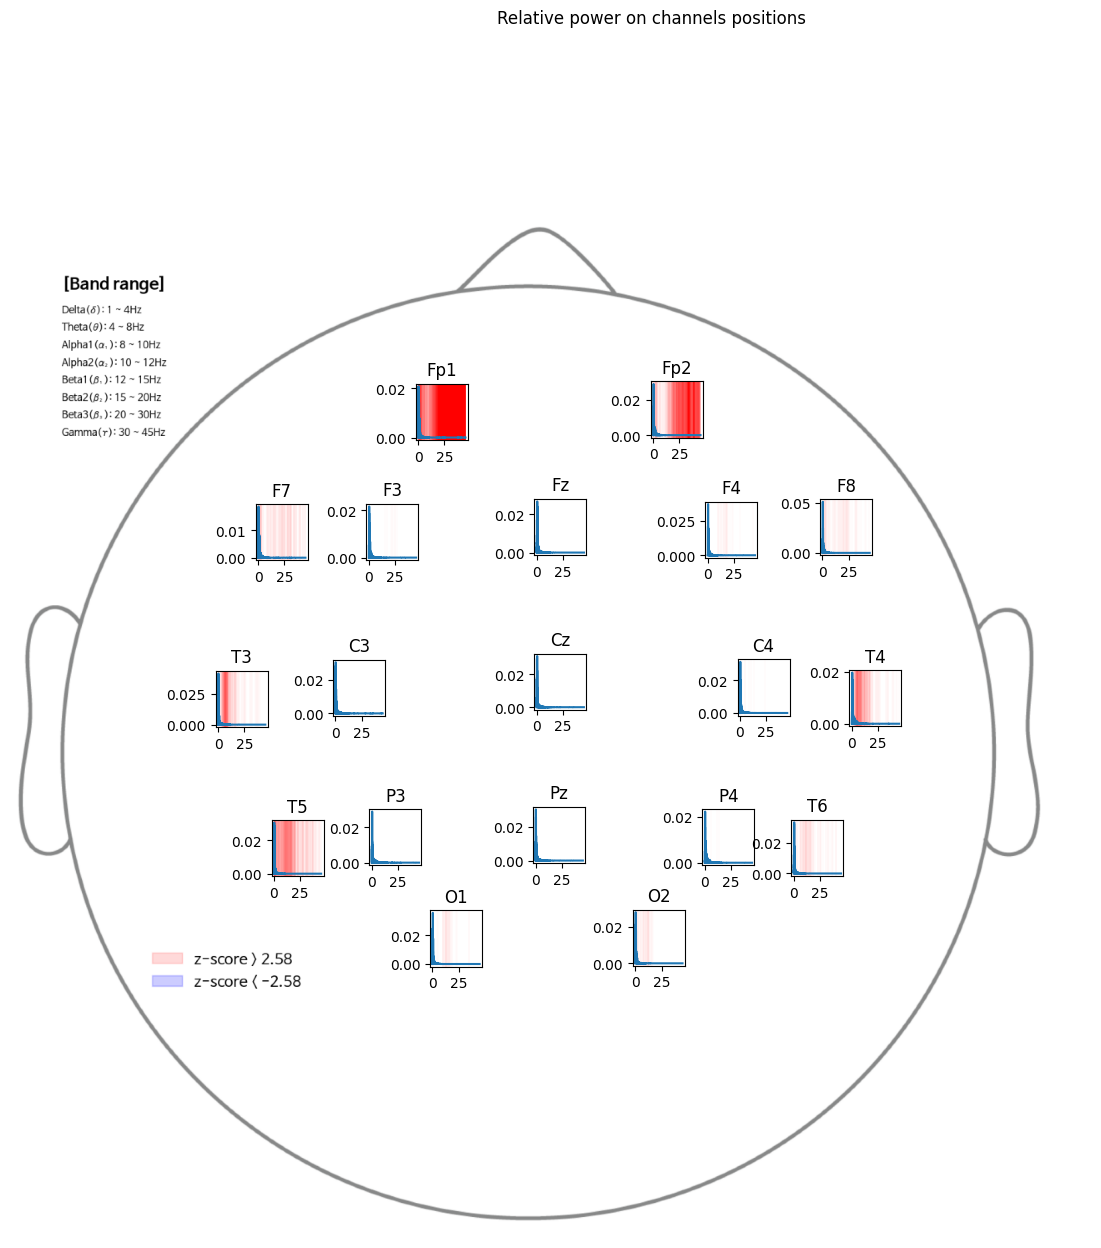

In [ ]:
# %% Relative power on channels positions
fig, ax = plt.subplots(figsize=(20, 15))
with get_sample_data('/content/sample_data/backgroundTopo.png') as file:
    img = plt.imread(file)
imagebox = OffsetImage(img, zoom=0.6)
ab = AnnotationBbox(imagebox, (0.46, 0.5), xycoords='data', frameon=False)
ax.add_artist(ab)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_visible(False)
# changing the start of plotting the axes and the width and height
ax.set_position([0.2, 0.25, 0.52, 0.5])

layout = mne.channels.make_eeg_layout(data_refer.info)
xy = layout.pos[:, 0:2]
# Absolute with DB
for i, label in enumerate(layout.names):
    # Add inset subplot at specific location
    inset_ax = inset_axes(ax, width="10%", height="10%", loc=3,
                          bbox_to_anchor=(xy[i, 0], xy[i, 1], 0.5, 0.75), bbox_transform=ax.transAxes)
    inset_ax.set_title(label)
    for j in range(len(f)):
        if psd_z[i, j] > 2.58:
            inset_ax.axvline(x=f[j], color='red', alpha=0.01)
        if psd_z[i, j] < -2.58:
            inset_ax.axvline(x=f[j], color='blue', alpha=0.01)
    inset_ax.plot(f, psd[i, :] / np.sum(psd[i, :], axis=0))
fig.suptitle("Relative power on channels positions")
pdf.savefig(fig)

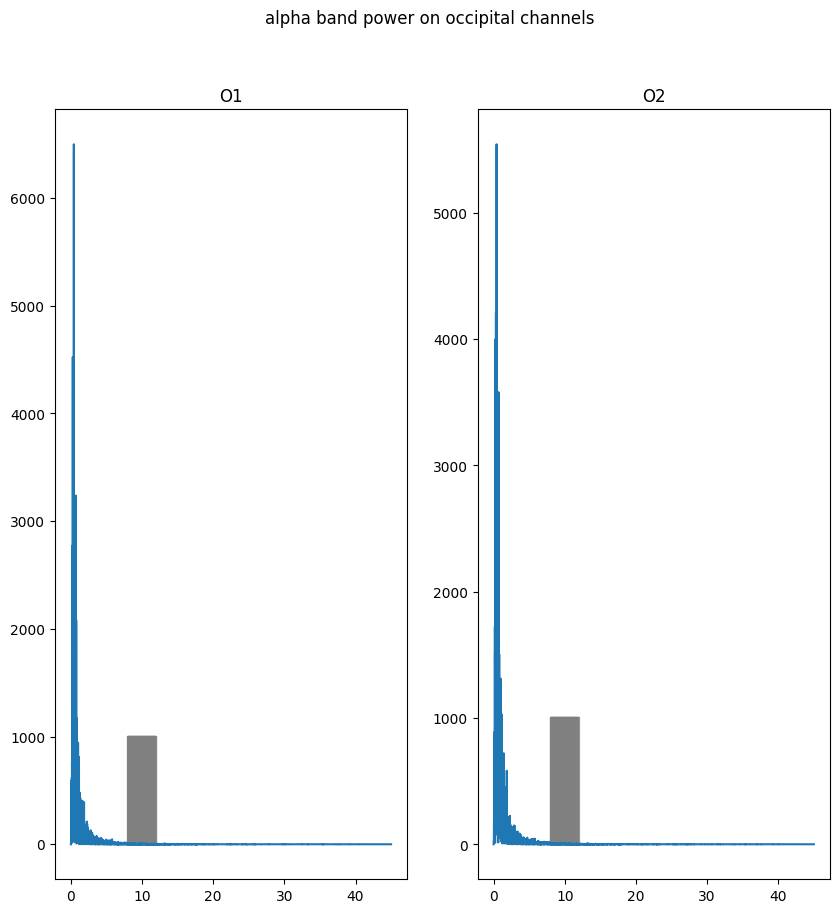

In [ ]:
# %% alpha band power on occipital channels
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
c = 0
for i, label in enumerate(layout.names):
    if label == 'O1' or label == 'O2':
        ax[c].set_title(label)
        for j in range(len(f)):
            if f[j] >= 8 and f[j] <= 12:  # alpha range
                ax[c].plot([f[j], f[j]], [0, 1000],
                           color='gray', alpha=0.1)  # the region to look at for the peak
        ax[c].plot(f, psd[i, :])
        c += 1
fig.suptitle("alpha band power on occipital channels")
pdf.savefig(fig)

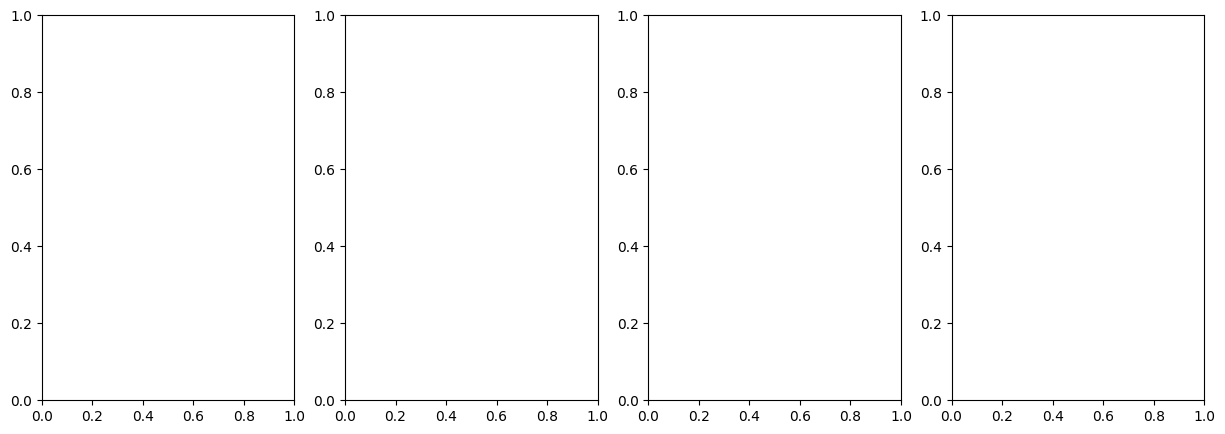

In [ ]:
# %% Power ratio
Bands = ['Theta/beta1 ratio (TBR)', 'Theta/beta2 ratio (TBR2)',
         'Theta/alpha ratio (TAR)', 'Delta/alpha ratio (DAR)']
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

In [ ]:
# Theta/beta1 ratio
Bands_freq1 = [4, 8]
Bands_freq2 = [13, 15]
TBR = bands_to_ratio(Bands_freq1, Bands_freq2, f, psd)
evoked = mne.EvokedArray(data_refer.get_data(), data_refer.info)
evoked.set_eeg_reference('average', projection=True)
power_band_topo = np.interp(TBR, (np.min(
    TBR), np.max(TBR)), (-2.6, 2.6))  # rescaling the values .. zscoring will be done before that this is for plotting within range ..
evoked = mne.EvokedArray(power_band_topo[:, np.newaxis], evoked.info)
evoked.plot_topomap(0, ch_type="eeg",
                    show_names=True, contours=0, cmap='jet', size=5,  colorbar=False, axes=ax[0])
ax[0].set_title(Bands[0])

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


Text(0.5, 1.0, 'Theta/beta1 ratio (TBR)')

In [ ]:
# Theta/beta2 ratio
Bands_freq1 = [4, 8]
Bands_freq2 = [15, 21]
TBR2 = bands_to_ratio(Bands_freq1, Bands_freq2, f, psd)
evoked = mne.EvokedArray(data_refer.get_data(), data_refer.info)
evoked.set_eeg_reference('average', projection=True)
power_band_topo = np.interp(TBR2, (np.min(
    TBR2), np.max(TBR2)), (-2.6, 2.6))  # rescaling the values .. zscoring will be done before that this is for plotting within range ..
evoked = mne.EvokedArray(power_band_topo[:, np.newaxis], evoked.info)
evoked.plot_topomap(0, ch_type="eeg",
                    show_names=True, contours=0, cmap='jet', size=5,  colorbar=False, axes=ax[1])
ax[1].set_title(Bands[1])

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


Text(0.5, 1.0, 'Theta/beta2 ratio (TBR2)')

In [ ]:
# Theta/alpha ratio
Bands_freq1 = [4, 8]
Bands_freq2 = [8, 12]
TAR = bands_to_ratio(Bands_freq1, Bands_freq2, f, psd)
evoked = mne.EvokedArray(data_refer.get_data(), data_refer.info)
evoked.set_eeg_reference('average', projection=True)
power_band_topo = np.interp(TAR, (np.min(
    TAR), np.max(TAR)), (-2.6, 2.6))  # rescaling the values .. zscoring will be done before that this is for plotting within range ..
evoked = mne.EvokedArray(power_band_topo[:, np.newaxis], evoked.info)
evoked.plot_topomap(0, ch_type="eeg",
                    show_names=True, contours=0, cmap='jet', size=5,  colorbar=False, axes=ax[2])
ax[2].set_title(Bands[2])

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


Text(0.5, 1.0, 'Theta/alpha ratio (TAR)')

In [ ]:
# Delta/alpha ratio
Bands_freq1 = [1, 4]
Bands_freq2 = [8, 12]
DAR = bands_to_ratio(Bands_freq1, Bands_freq2, f, psd)
evoked = mne.EvokedArray(data_refer.get_data(), data_refer.info)
evoked.set_eeg_reference('average', projection=True)
power_band_topo = np.interp(DAR, (np.min(
    DAR), np.max(DAR)), (-2.6, 2.6))  # rescaling the values .. zscoring will be done before that this is for plotting within range ..
evoked = mne.EvokedArray(power_band_topo[:, np.newaxis], evoked.info)
evoked.plot_topomap(0, ch_type="eeg",
                    show_names=True, contours=0, cmap='jet', size=5,  colorbar=False, axes=ax[3])
ax[3].set_title(Bands[3])

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


Text(0.5, 1.0, 'Delta/alpha ratio (DAR)')

In [ ]:
cbar_ax = fig.add_axes([0.92, 0.1, 0.05, 0.7])
norm = plt.Normalize(vmin=-2.6,
                     vmax=2.6)  # np.min(power_band_topo)
sm = cm.ScalarMappable(cmap='jet', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title('z-score')

fig.suptitle("Power ratio")
pdf.savefig(fig)


pdf.close()